In [ ]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def basic_tokenize(text):
    return word_tokenize(text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


add custom tokenization to better understand the structure of ChatGPT conversations. For instance, it could recognize code snippets, lists, or special formatting.

In [ ]:
import re

def is_code_snippet(text):
    # Example: simple check for Python-like function definitions
    return bool(re.search(r'def\s+\w+\(.*\):', text))

def is_list_item(text):
    # Example: check for bullet points or numbers
    return bool(re.match(r'^(\*|\d+\.)', text))


In [ ]:

def custom_tokenize(text):
    # Patterns to recognize specific elements in ChatGPT conversations
    code_snippet_pattern = re.compile(r"```[\s\S]*?```")  # Detects code blocks
    list_pattern = re.compile(r"(\n\s*-.*?)+")           # Detects lists
    bold_pattern = re.compile(r"\*\*.*?\*\*")            # Detects bold text

    # Replace each special element with a unique token
    text = code_snippet_pattern.sub("<CODE_SNIPPET>", text)
    text = list_pattern.sub("<LIST>", text)
    text = bold_pattern.sub("<BOLD_TEXT>", text)

    # Basic tokenization by splitting on whitespace
    tokens = text.split()

    return tokens



In [ ]:
import zipfile
import os

# Unzip dataset
with zipfile.ZipFile("project-material.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

# Check the files in the unzipped directory
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


data/scores.csv
data/dataset.zip
data/Assignment.ipynb
data/dataset/dataset/da219169-aacb-48b8-abdc-e25f08ad029e.html
data/dataset/dataset/0031c86e-81f4-4eef-9e0e-28037abf9883.html
data/dataset/dataset/090d6217-5d69-4929-a342-19abab78324f.html
data/dataset/dataset/597c7a93-6b16-4af9-9846-154599f596e1.html
data/dataset/dataset/6a903495-c5be-4263-b4dd-75e2bbc30434.html
data/dataset/dataset/f2f18684-4a16-4c05-a2d1-c0f96d1de869.html
data/dataset/dataset/36bab6e3-0d16-4626-846b-33c0384f0c79.html
data/dataset/dataset/8a84e6e5-d200-4cc2-a288-5c81201100c7.html
data/dataset/dataset/c91d6fef-baf5-4e77-8bfc-b14fb7fc770d.html
data/dataset/dataset/139235c7-736c-4237-92f0-92e8c116832c.html
data/dataset/dataset/152a7787-ecd1-448f-a98e-8af0826d8215.html
data/dataset/dataset/c65a33f5-6acf-4ff1-86fe-6003f165d44e.html
data/dataset/dataset/5541316f-6fbd-4441-b513-ac252e6355ec.html
data/dataset/dataset/14ce054d-4619-4685-ba9b-4b5cd6f81b2d.html
data/dataset/dataset/dfe46143-c07c-4bb6-bddc-7458995dba2f.html


In [ ]:
# Unzipping dataset.zip
with zipfile.ZipFile("data/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("data/dataset")

# Check the files in the unzipped directory
for dirname, _, filenames in os.walk('data/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))




data/dataset/dataset/da219169-aacb-48b8-abdc-e25f08ad029e.html
data/dataset/dataset/0031c86e-81f4-4eef-9e0e-28037abf9883.html
data/dataset/dataset/090d6217-5d69-4929-a342-19abab78324f.html
data/dataset/dataset/597c7a93-6b16-4af9-9846-154599f596e1.html
data/dataset/dataset/6a903495-c5be-4263-b4dd-75e2bbc30434.html
data/dataset/dataset/f2f18684-4a16-4c05-a2d1-c0f96d1de869.html
data/dataset/dataset/36bab6e3-0d16-4626-846b-33c0384f0c79.html
data/dataset/dataset/8a84e6e5-d200-4cc2-a288-5c81201100c7.html
data/dataset/dataset/c91d6fef-baf5-4e77-8bfc-b14fb7fc770d.html
data/dataset/dataset/139235c7-736c-4237-92f0-92e8c116832c.html
data/dataset/dataset/152a7787-ecd1-448f-a98e-8af0826d8215.html
data/dataset/dataset/c65a33f5-6acf-4ff1-86fe-6003f165d44e.html
data/dataset/dataset/5541316f-6fbd-4441-b513-ac252e6355ec.html
data/dataset/dataset/14ce054d-4619-4685-ba9b-4b5cd6f81b2d.html
data/dataset/dataset/dfe46143-c07c-4bb6-bddc-7458995dba2f.html
data/dataset/dataset/5a62a8ee-c67c-475e-bd85-cf6d83c90e

In [ ]:
import re
import os
import tqdm
from glob import glob
from bs4 import BeautifulSoup
data_path = "data/dataset/dataset/*.html"

file_paths = sorted(list(glob(data_path)))

print("Number of files found:", len(file_paths))
code2convos = dict()

pbar = tqdm.tqdm(file_paths)
for path in pbar:
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
        html_page = fh.read()
        soup = BeautifulSoup(html_page, "html.parser")
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_list = []  # List to store each conversation dictionary
        for convo in conversations:
            elements = convo.find_all("div", attrs={"data-message-author-role": re.compile(r"[user|assistant]")})
            if elements:
                role = elements[0].get("data-message-author-role")
                text = elements[0].text
                tokenized_text = custom_tokenize(text)


                convo_dict = {
                    "role": role,
                    "text": text,
                    "tokenized": tokenized_text,

                }
                convo_list.append(convo_dict)




        code2convos[file_code] = convo_list  # Store the list of conversations

# Example to print the first conversation of the first file
first_key = list(code2convos.keys())[0]
if code2convos[first_key]:  # Check if there are conversations
    print(f"First conversation for code {first_key}:")
    print(code2convos[first_key][0])  # Print the first conversation
else:
    print("No conversations available for this code.")


Number of files found: 127


100%|██████████| 127/127 [00:55<00:00,  2.29it/s]

First conversation for code 0031c86e-81f4-4eef-9e0e-28037abf9883:
{'role': 'user', 'text': "Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n", 'tokenized': ['Load', 'a', 'CSV', 'file', 'into', 'a', 'Pandas', 'in', 'Python.', 'The', 'file', 'is', 'named', "'cs412_hw1_dataset.csv'", 'and', 'contains', 'columns', 'like', "'Species',", "'Island',", "'Sex',", "'Diet',", "'Year',", "'Life", "Stage',", "'Body", 'Mass', "(g)',", "'Bill", 'Length', "(mm)',", "'Bill", 'Depth', "(mm)',", "'Flipper", 'Length', "(mm)',", 'and', "'Health", "Metrics'."]}


In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Example: Reading the scores data
scores = pd.read_csv("data/scores.csv")

# Check for missing values
print("Missing values before imputation:\n", scores.isnull().sum())

# Imputing missing values in 'grade' column only
imputer = SimpleImputer(strategy="median")
scores['grade'] = imputer.fit_transform(scores[['grade']])

# Check to ensure missing values in 'grade' are filled
print("\nMissing values after imputation:\n", scores.isnull().sum())

Missing values before imputation:
 Unnamed: 0    0
code          0
grade         1
dtype: int64

Missing values after imputation:
 Unnamed: 0    0
code          0
grade         0
dtype: int64


In [ ]:
# let's see one of the conversations
print(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user', 'text': "Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n", 'tokenized': ['Load', 'a', 'CSV', 'file', 'into', 'a', 'Pandas', 'in', 'Python.', 'The', 'file', 'is', 'named', "'cs412_hw1_dataset.csv'", 'and', 'contains', 'columns', 'like', "'Species',", "'Island',", "'Sex',", "'Diet',", "'Year',", "'Life", "Stage',", "'Body", 'Mass', "(g)',", "'Bill", 'Length', "(mm)',", "'Bill", 'Depth', "(mm)',", "'Flipper", 'Length', "(mm)',", 'and', "'Health", "Metrics'."]}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [ ]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [ ]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [ ]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [ ]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [ ]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

In [ ]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [ ]:

code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


In [ ]:
question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


In [ ]:
questions[4]

In [ ]:
from sklearn.cluster import KMeans

# Assuming prompts_TF_IDF is a matrix of TF-IDF features of prompts
kmeans = KMeans(n_clusters=len(questions), random_state=0)
prompt_clusters = kmeans.fit_predict(prompts_TF_IDF)

# Create a mapping from codes to their respective cluster indices
prompt_cluster_mapping = {code: cluster for code, cluster in zip(code2prompts.keys(), prompt_clusters)}

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity
cluster_centroids = kmeans.cluster_centers_
question_vectors = vectorizer.transform(questions).toarray()
similarity_scores = cosine_similarity(cluster_centroids, question_vectors)

# Map each cluster to its most similar question
question_cluster_mapping = np.argmax(similarity_scores,axis=1)

In [ ]:
code_to_question_mapping = {code: question_cluster_mapping[prompt_cluster_mapping[code]]
                            for code in code2prompts if code in prompt_cluster_mapping}

In [ ]:
mapped_data = []
for code, prompts in code2prompts.items():
    if code in prompt_cluster_mapping:
        cluster_index = prompt_cluster_mapping[code]
        question = questions[question_cluster_mapping[cluster_index]]
        for prompt in prompts:
            mapped_data.append({'code': code, 'prompt': prompt, 'question': question})
    else:
        # handle or log the missing code
        print(f"Code {code} not found in cluster mapping.")

mapped_df = pd.DataFrame(mapped_data)

Code 410d88de-2489-4a83-8dae-6bc01e8e9f78 not found in cluster mapping.
Code 41b82427-7ae2-4c55-b8a3-310bb4abada0 not found in cluster mapping.
Code 42980d53-7bcd-4a36-bf3a-aa43f7417ac5 not found in cluster mapping.
Code 43ff9786-2b47-425b-8bad-e274d9988a0e not found in cluster mapping.
Code 450550b4-3bb9-4b12-a7fd-121ac4a36ea9 not found in cluster mapping.
Code 45d2c21a-828e-46d9-8fcd-a4a39888773c not found in cluster mapping.
Code 4e6fdf20-96fa-4f62-bf55-5c4c695afebe not found in cluster mapping.
Code 4fb21782-81f0-47c1-8831-58a748904a2c not found in cluster mapping.
Code 50a71154-2269-460c-9341-291221c6ef02 not found in cluster mapping.
Code 51f35201-da77-4b6d-a455-99cc84195c5c not found in cluster mapping.
Code 530b4e58-756d-4627-ad08-65ba0457ad42 not found in cluster mapping.
Code 53ad17d1-5eb2-4af6-9c38-3c90c05ee695 not found in cluster mapping.
Code 5541316f-6fbd-4441-b513-ac252e6355ec not found in cluster mapping.
Code 56c6f8dd-f37c-44d2-9820-9459aa34c8af not found in cluster m

In [ ]:
# Sample inspection
for code, question_id in list(code_to_question_mapping.items())[:130]:  # Inspect the first 5 mappings
    print(f"Code: {code}, Mapped Question:{question_id}")

Code: 0031c86e-81f4-4eef-9e0e-28037abf9883, Mapped Question:2
Code: 0225686d-b825-4cac-8691-3a3a5343df2b, Mapped Question:2
Code: 041f950b-c013-409a-a642-cffff60b9d4b, Mapped Question:6
Code: 04f91058-d0f8-4324-83b2-19c671f433dc, Mapped Question:2
Code: 089eb66d-4c3a-4f58-b98f-a3774a2efb34, Mapped Question:2
Code: 090d6217-5d69-4929-a342-19abab78324f, Mapped Question:2
Code: 0c95c563-f1e1-4a35-844c-2e8ccdd1b161, Mapped Question:2
Code: 0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc, Mapped Question:0
Code: 0e466794-f7f8-4cc2-b07e-070b13a0b5e1, Mapped Question:0
Code: 0f0c953a-a472-47c1-809b-9fc14dba9091, Mapped Question:2
Code: 1029802d-1057-4e3e-b827-e8a9c2ded3b9, Mapped Question:2
Code: 1038cb22-8ad2-4030-b44a-59f10352e91c, Mapped Question:2
Code: 106ffe99-c787-4d09-9076-4ba411eb68b1, Mapped Question:0
Code: 139235c7-736c-4237-92f0-92e8c116832c, Mapped Question:2
Code: 14ce054d-4619-4685-ba9b-4b5cd6f81b2d, Mapped Question:2
Code: 152a7787-ecd1-448f-a98e-8af0826d8215, Mapped Question:2
Code: 17

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
questions_vectors = vectorizer.transform(questions).toarray()
#n_clusters is set to the number of defined questions
n_clusters = len(questions)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

code_to_question_mapping = {}

# Variables to track the number of skipped codes
skipped_codes = 0
total_codes = len(code2prompts_tf_idf)

for code, tf_idf_matrix in code2prompts_tf_idf.items():
    # Skip clustering if the number of prompts is less than the number of clusters
    if tf_idf_matrix.shape[0] < n_clusters:
        skipped_codes += 1
        continue

    clusters = kmeans.fit_predict(tf_idf_matrix)

    cluster_centroids = kmeans.cluster_centers_
    cluster_to_question = {}
    for i, centroid in enumerate(cluster_centroids):
        centroid = centroid.reshape(1, -1)
        similarities = cosine_similarity(centroid, questions_vectors)
        most_similar_question_index = np.argmax(similarities)
        cluster_to_question[i] = questions[most_similar_question_index]

    most_frequent_cluster = pd.Series(clusters).mode()[0]
    code_to_question_mapping[code] = cluster_to_question[most_frequent_cluster]

# Print the number of skipped and total codes
print(f"Skipped {skipped_codes} out of {total_codes} codes.")

# Now 'code_to_question_mapping' contains the mapping of each code to the most relevant question
prompt_question_mappings = []

for code, tf_idf_matrix in code2prompts_tf_idf.items():
    if tf_idf_matrix.shape[0] < n_clusters:
        # Skipping codes with fewer prompts than clusters
        continue

    # Apply KMeans clustering
    clusters = kmeans.fit_predict(tf_idf_matrix)

    # Map each prompt in this code to the corresponding question
    for prompt, cluster_label in zip(code2prompts[code], clusters):
        mapped_question = cluster_to_question[cluster_label]
        prompt_question_mappings.append({'Code': code, 'Prompt': prompt, 'Mapped Question': mapped_question})

# Convert the list of mappings to a DataFrame
mappings_df = pd.DataFrame(prompt_question_mappings)

# Display the DataFrame
print(mappings_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Skipped 9 out of 123 codes.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

                                      Code  \
0     0031c86e-81f4-4eef-9e0e-28037abf9883   
1     0031c86e-81f4-4eef-9e0e-28037abf9883   
2     0031c86e-81f4-4eef-9e0e-28037abf9883   
3     0031c86e-81f4-4eef-9e0e-28037abf9883   
4     0031c86e-81f4-4eef-9e0e-28037abf9883   
...                                    ...   
3505  fb8de815-224c-4d06-9fd4-7156d1a9920d   
3506  fb8de815-224c-4d06-9fd4-7156d1a9920d   
3507  fb8de815-224c-4d06-9fd4-7156d1a9920d   
3508  fb8de815-224c-4d06-9fd4-7156d1a9920d   
3509  fb8de815-224c-4d06-9fd4-7156d1a9920d   

                                                 Prompt  \
0     Load a CSV file into a Pandas in Python. The f...   
1     Provide Python code to understand a dataset us...   
2     You will preprocess the data now\n1. Check for...   
3     You already provide code for this but please r...   
4     Calculate and Visualize the correlations of al...   
...                                                 ...   
3505  i have encountered this erro

# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [ ]:
import re
import os
import tqdm
from glob import glob
from bs4 import BeautifulSoup


# Function to count follow-up questions
def count_follow_ups(convo_texts):
    # Logic to count follow-up questions
    return len([text for text in convo_texts if 'role' in text and text['role'] == 'user'])  # Example logic

# Function to detect repeated questions
def detect_repeated_questions(convo_texts):
    # Logic to detect repeated questions
    user_texts = [text['text'] for text in convo_texts if 'role' in text and text['role'] == 'user']
    return len(set(user_texts)) != len(user_texts)  # Example logic

# Function to calculate average response length
def average_response_length(convo_texts):
    # Logic to calculate average length of responses
    response_lengths = [len(text['text']) for text in convo_texts if 'role' in text and text['role'] == 'assistant']
    return sum(response_lengths) / len(response_lengths) if response_lengths else 0

# Function to count confusion instances
def count_confusion_instances(convo_texts):
    # Logic to count instances of confusion keywords
    confusion_keywords = ['I don\'t understand', 'Can you explain again']
    return sum(any(keyword in text['text'] for keyword in confusion_keywords) for text in convo_texts if 'role' in text and text['role'] == 'user')

In [ ]:
from textblob import TextBlob

def analyze_text_liwc(text):
    analysis = TextBlob(text)
    return {
        "polarity": analysis.sentiment.polarity,
        "subjectivity": analysis.sentiment.subjectivity
        # You can add more categories based on your needs
    }


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from textblob import TextBlob
from textblob.np_extractors import ConllExtractor
from textblob.taggers import NLTKTagger

def analyze_text_liwc(text):
    analysis = TextBlob(text, np_extractor=ConllExtractor(), pos_tagger=NLTKTagger())

    # Sentiment Analysis:
    polarity = analysis.sentiment.polarity
    subjectivity = analysis.sentiment.subjectivity

    #counting pronouns:
    first_person_pronouns = sum(word.lower() in ['i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours'] for word in analysis.words)
    second_person_pronouns = sum(word.lower() in ['you', 'your', 'yours'] for word in analysis.words)
    third_person_pronouns = sum(word.lower() in ['he', 'him', 'his', 'she', 'her', 'hers', 'they', 'them', 'their', 'theirs'] for word in analysis.words)

    # counting verbs like "can," "could," "may," for cognitive process
    cognitive_verbs = sum(word.lower() in ['can', 'could', 'may', 'might', 'will', 'would', 'must', 'shall', 'should', 'ought to'] for word, tag in analysis.tags if tag.startswith('MD'))



    return {
        "polarity": polarity,
        "subjectivity": subjectivity,
        "first_person_pronouns": first_person_pronouns,
        "second_person_pronouns": second_person_pronouns,
        "third_person_pronouns": third_person_pronouns,
        "cognitive_verbs": cognitive_verbs,


    }


In [ ]:
from collections import defaultdict
import re

code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue


    code2features[code]['follow_ups'] = count_follow_ups(convs)
    code2features[code]['repeated_questions'] = detect_repeated_questions(convs)
    code2features[code]['average_response_length'] = average_response_length(convs)
    code2features[code]['confusion_instances'] = count_confusion_instances(convs)

    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts
            code2features[code]["#user_prompts"] += 1

            # LIWC Analysis
            liwc_results = analyze_text_liwc(text)
            for key, value in liwc_results.items():
                code2features[code][key] += value

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] += len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

    # Calculate average characters
    if code2features[code]["#user_prompts"] > 0:
        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

# Now code2features contains all the features including LIWC analysis and conversation flow metrics

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [ ]:
df = pd.DataFrame(code2features).T
df.head(5)

,follow_ups,repeated_questions,average_response_length,confusion_instances,#user_prompts,polarity,subjectivity,first_person_pronouns,second_person_pronouns,third_person_pronouns,cognitive_verbs,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14,False,2218.5,0,14,1.952403,5.91039,16,5,7,10,3,1,0,0,0,407.214286,2218.5
0225686d-b825-4cac-8691-3a3a5343df2b,18,False,1653.111111,0,18,2.352917,4.810694,8,24,5,16,0,0,0,0,3,261.111111,1653.111111
041f950b-c013-409a-a642-cffff60b9d4b,9,False,1636.222222,0,9,-0.192029,2.474638,4,26,5,16,3,0,1,0,3,663.0,1636.222222
04f91058-d0f8-4324-83b2-19c671f433dc,20,False,1749.9,0,20,0.080833,4.509167,18,0,3,9,1,1,0,0,3,114.1,1749.9
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,True,1455.44186,0,86,7.697567,26.539612,61,34,16,42,1,5,0,0,26,217.081395,1455.44186


In [ ]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


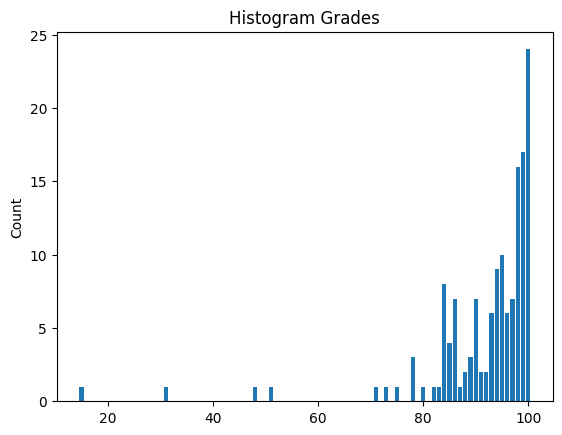

In [ ]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [ ]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,follow_ups,repeated_questions,average_response_length,confusion_instances,#user_prompts,polarity,subjectivity,first_person_pronouns,second_person_pronouns,third_person_pronouns,cognitive_verbs,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14,False,2218.5,0,14,1.952403,5.91039,16,5,7,10,3,1,0,0,0,407.214286,2218.5
1,0225686d-b825-4cac-8691-3a3a5343df2b,18,False,1653.111111,0,18,2.352917,4.810694,8,24,5,16,0,0,0,0,3,261.111111,1653.111111
2,041f950b-c013-409a-a642-cffff60b9d4b,9,False,1636.222222,0,9,-0.192029,2.474638,4,26,5,16,3,0,1,0,3,663.0,1636.222222
3,04f91058-d0f8-4324-83b2-19c671f433dc,20,False,1749.9,0,20,0.080833,4.509167,18,0,3,9,1,1,0,0,3,114.1,1749.9
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,True,1455.44186,0,86,7.697567,26.539612,61,34,16,42,1,5,0,0,26,217.081395,1455.44186


In [ ]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,follow_ups,repeated_questions,average_response_length,confusion_instances,#user_prompts,polarity,subjectivity,first_person_pronouns,second_person_pronouns,...,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14,False,2218.5,0,14,1.952403,5.91039,16,5,...,2218.5,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,18,False,1653.111111,0,18,2.352917,4.810694,8,24,...,1653.111111,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,9,False,1636.222222,0,9,-0.192029,2.474638,4,26,...,1636.222222,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,20,False,1749.9,0,20,0.080833,4.509167,18,0,...,1749.9,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,True,1455.44186,0,86,7.697567,26.539612,61,34,...,1455.44186,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769


#### Merging scores with features

In [ ]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,follow_ups,repeated_questions,average_response_length,confusion_instances,#user_prompts,polarity,subjectivity,first_person_pronouns,second_person_pronouns,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14,False,2218.5,0,14,1.952403,5.91039,16,5,...,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18,False,1653.111111,0,18,2.352917,4.810694,8,24,...,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9,False,1636.222222,0,9,-0.192029,2.474638,4,26,...,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20,False,1749.9,0,20,0.080833,4.509167,18,0,...,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,True,1455.44186,0,86,7.697567,26.539612,61,34,...,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,100.0


In [ ]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 27) (122,)


#### Train/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_train.astype('float32')
y_test = y_train.astype('float32')



In [ ]:
model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=10)

Epoch 1/100
9/9 [==============================] - 2s 35ms/step - loss: 75641.2500 - val_loss: 7947.1279
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 3494.4702 - val_loss: 4087.0188
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 6424.8364 - val_loss: 1447.3752
Epoch 4/100
9/9 [==============================] - 0s 6ms/step - loss: 1110.0192 - val_loss: 767.0702
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 1365.1559 - val_loss: 1218.5664
Epoch 6/100
9/9 [==============================] - 0s 6ms/step - loss: 783.5240 - val_loss: 192.3827
Epoch 7/100
9/9 [==============================] - 0s 6ms/step - loss: 736.2959 - val_loss: 180.6379
Epoch 8/100
9/9 [==============================] - 0s 6ms/step - loss: 673.5444 - val_loss: 291.0624
Epoch 9/100
9/9 [==============================] - 0s 7ms/step - loss: 583.9394 - val_loss: 304.6749
Epoch 10/100
9/9 [==============================] - 0s 6ms/step - loss: 580.2322

In [ ]:
mse = model.evaluate(X_test, y_test)
print('Mean Squared Error:',mse)

4/4 [==============================] - 0s 4ms/step - loss: 333.1613
Mean Squared Error: 333.1612548828125
